In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%qtconsole
%load_ext snakeviz
import sys
import collections
import itertools
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sys.path.append('../src/')
import data_processing
import ripple_detection
import spectral

Animal = collections.namedtuple('Animal', {'directory', 'short_name'})
animals = {'HPa': Animal(directory='HPa_direct', short_name='HPa')}
epoch_index = ('HPa', 8, 2)
sampling_frequency = 1500
tetrode_info = data_processing.make_tetrode_dataframe(animals)[epoch_index]
tetrode_info = tetrode_info[~tetrode_info.descrip.str.endswith('Ref').fillna(False)]
print(tetrode_info.loc[:, ['area', 'depth', 'descrip']])
lfps = {index: data_processing.get_LFP_dataframe(index, animals)
        for index in tetrode_info.index}

                                     area  depth descrip
animal day epoch_ind tetrode_number                     
HPa    8   2         1                CA1    113  riptet
                     2                CA1    121     NaN
                     4                CA1    116  riptet
                     5                CA1    116  riptet
                     6                CA1    110  riptet
                     7                CA1    114  riptet
                     8               iCA1    114  riptet
                     9               iCA1    100  riptet
                     10              iCA1     96     NaN
                     11              iCA1    106  riptet
                     12              iCA1    114  riptet
                     13              iCA1    120     NaN
                     14              iCA1    105  riptet
                     15               PFC     93     NaN
                     16               PFC     90     NaN
                     17        

In [2]:
area_pairs = list(itertools.combinations(tetrode_info.area.unique(), 2))
area_pairs

[('CA1', 'iCA1'), ('CA1', 'PFC'), ('iCA1', 'PFC')]

In [3]:
ripple_times = ripple_detection.get_epoch_ripples(
        epoch_index, animals, sampling_frequency=sampling_frequency)
reshaped_lfps = {key: data_processing.reshape_to_segments(
            lfps[key], ripple_times,
            sampling_frequency=sampling_frequency,
            window_offset=(-2.100, 2.100), concat_axis=1).dropna()
            for key in lfps}


Detecting ripples for Animal HPa, Day 8, Epoch #2...



In [4]:
area1, area2 = area_pairs[0]

def get_lfps_by_area(area, tetrode_info, lfps):
    return [lfps[index] for index in tetrode_info[tetrode_info.area == area].index]

area1_lfps = get_lfps_by_area(area1, tetrode_info, reshaped_lfps)
area2_lfps = get_lfps_by_area(area2, tetrode_info, reshaped_lfps)

In [5]:
area1_lfps[0].shape

(4493, 151)

In [6]:
area2_lfps[0].shape

(4493, 151)

In [7]:
gamma_frequency_params = dict(
    sampling_frequency=sampling_frequency,
    time_window_duration=0.600,
    time_window_step=0.600,
    desired_frequencies=[20, 100],
    time_halfbandwidth_product=3,
    window_of_interest=(-2.100, 2.100)
)

In [8]:
tapers, number_of_fft_samples, frequencies, freq_ind = spectral._set_default_multitaper_parameters(
    number_of_time_samples=area1_lfps[0].shape[0],
    sampling_frequency=gamma_frequency_params['sampling_frequency'],
    time_halfbandwidth_product=gamma_frequency_params['time_halfbandwidth_product'],
    desired_frequencies=gamma_frequency_params['desired_frequencies'])

In [9]:
data1 = [spectral._center_data(datum).values for datum in area1_lfps]
complex_spectra1 = [spectral._multitaper_fft(tapers, datum, number_of_fft_samples, sampling_frequency)
                   for datum in data1]

In [10]:
data2 = [spectral._center_data(datum).values for datum in area2_lfps]
complex_spectra2 = [spectral._multitaper_fft(tapers, datum, number_of_fft_samples, sampling_frequency)
                   for datum in data2]

In [11]:
complex_spectra1 = np.concatenate([spectra[np.newaxis, ...] for spectra in complex_spectra1])
complex_spectra2 = np.concatenate([spectra[np.newaxis, ...] for spectra in complex_spectra2])

In [12]:
U1, _, V1 = np.linalg.svd(complex_spectra1[:, freq_ind[0], :, :].reshape((complex_spectra1.shape[0], -1)),
                          full_matrices=False)
U2, _, V2 = np.linalg.svd(complex_spectra2[:, freq_ind[0], :, :].reshape((complex_spectra2.shape[0], -1)),
                          full_matrices=False)
Q = np.dot(np.dot(U1, V1), np.dot(U2, V2).conj().transpose())
_, s, _ = np.linalg.svd(Q, full_matrices=False)
s[0] ** 2

0.43772395225502475

The canonical coherence is biased by the number of members of the group. So three groups with unequal numbers of members in each group are not comparable. One way to compare is to restrict the number of members of each group to the minimum of all the groups and then resample the members so that all the members are included.

In [13]:
def get_complex_spectra(lfps, tapers, number_of_fft_samples, sampling_frequency):
    ''' Returns a numpy array of complex spectra (electrode x frequencies x (trials x tapers))
    for input into the canonical coherence
    '''
    centered_lfps = [spectral._center_data(lfp).values for lfp in lfps]
    complex_spectra = [spectral._multitaper_fft(tapers, lfp, number_of_fft_samples, sampling_frequency)
                       for lfp in centered_lfps]
    complex_spectra = np.concatenate([spectra[np.newaxis, ...] for spectra in complex_spectra])
    return complex_spectra.reshape((complex_spectra.shape[0], complex_spectra.shape[1], -1))

def compute_canonical(complex_spectra1, complex_spectra2, freq_ind):
    U1, _, V1 = np.linalg.svd(complex_spectra1[:, freq_ind, :], full_matrices=False)
    U2, _, V2 = np.linalg.svd(complex_spectra2[:, freq_ind, :], full_matrices=False)
    Q = np.dot(np.dot(U1, V1), np.dot(U2, V2).conj().transpose())
    _, s, _ = np.linalg.svd(Q, full_matrices=False)
    return s[0] ** 2

In [14]:
%%snakeviz

complex_spectra1 = get_complex_spectra(area1_lfps, tapers, number_of_fft_samples, sampling_frequency)
complex_spectra2 = get_complex_spectra(area2_lfps, tapers, number_of_fft_samples, sampling_frequency)

coh = [compute_canonical(complex_spectra1, complex_spectra2, freq) for freq in freq_ind]

 
*** Profile stats marshalled to file '/var/folders/rt/nhwr2l2937n0f8g854zq3s6w0000gn/T/tmp51nmic7t'. 


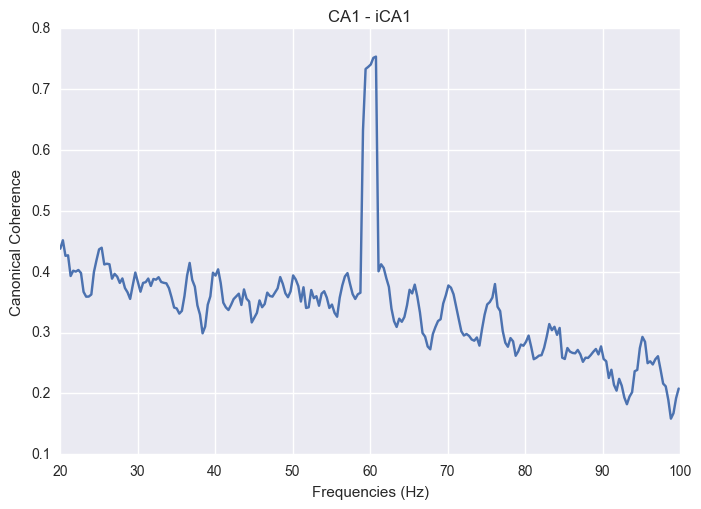

In [15]:
plt.plot(frequencies, coh)
plt.title('{} - {}'.format(area1, area2))
plt.xlabel('Frequencies (Hz)')
plt.ylabel('Canonical Coherence')

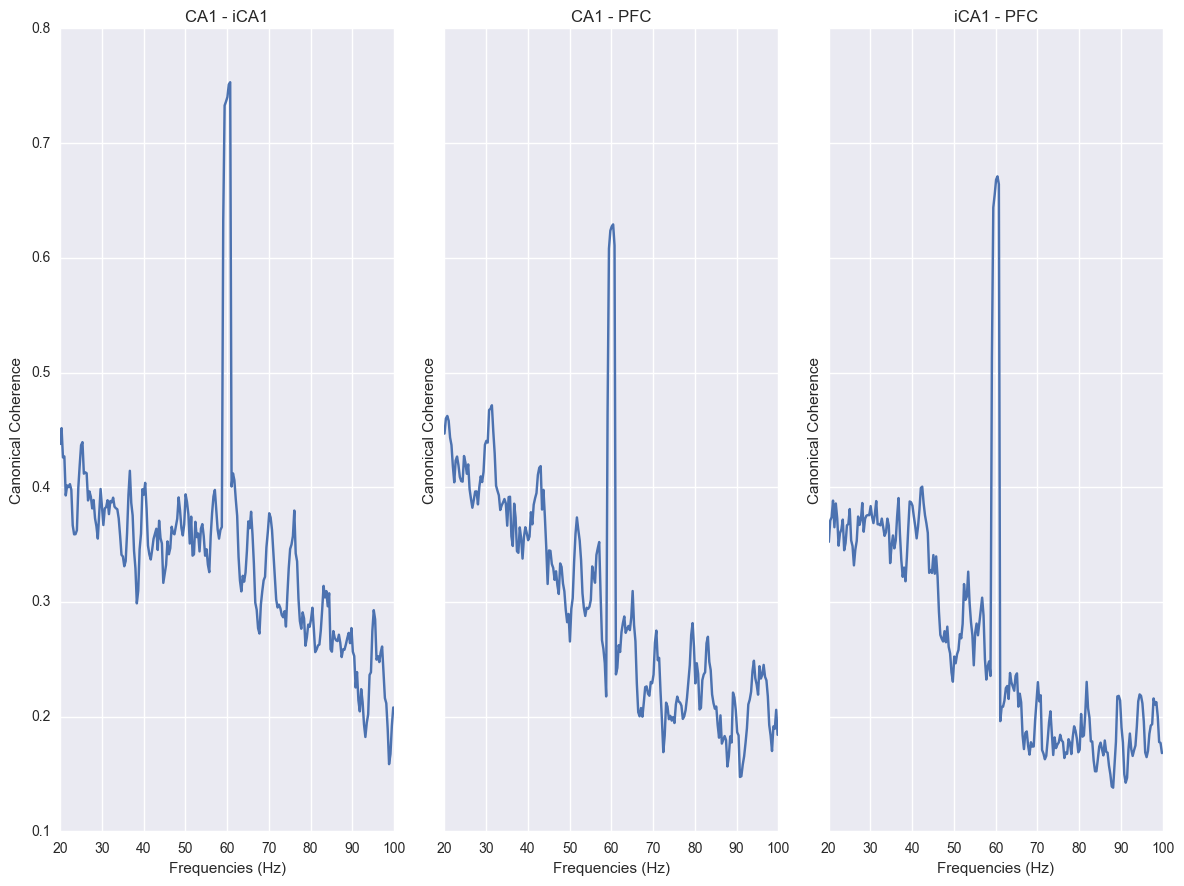

In [17]:
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(12,9))

for pair_ind, (area1, area2) in enumerate(area_pairs):
    area1_lfps = get_lfps_by_area(area1, tetrode_info, reshaped_lfps)
    area2_lfps = get_lfps_by_area(area2, tetrode_info, reshaped_lfps)
    complex_spectra1 = get_complex_spectra(area1_lfps, tapers, number_of_fft_samples, sampling_frequency)
    complex_spectra2 = get_complex_spectra(area2_lfps, tapers, number_of_fft_samples, sampling_frequency)
    coh = [compute_canonical(complex_spectra1, complex_spectra2, freq) for freq in freq_ind]
    axes[pair_ind].plot(frequencies, coh)
    axes[pair_ind].set_title('{area1} - {area2}'.format(area1=area1, area2=area2))
    axes[pair_ind].set_xlabel('Frequencies (Hz)')
    axes[pair_ind].set_ylabel('Canonical Coherence')
    
plt.tight_layout()

## Coherogram

In [18]:
time_window_duration = gamma_frequency_params['time_window_duration']
time_window_step = gamma_frequency_params['time_window_step']
time_halfbandwidth_product = gamma_frequency_params['time_halfbandwidth_product']
desired_frequencies = gamma_frequency_params['desired_frequencies']
pad = 0
number_of_tapers=None
tapers=None

time_step_length, time_window_length = spectral._get_window_lengths(
        time_window_duration,
        sampling_frequency,
        time_window_step)
tapers, number_of_fft_samples, frequencies, freq_ind = spectral._set_default_multitaper_parameters(
    number_of_time_samples=time_window_length,
    sampling_frequency=sampling_frequency,
    time_window_duration=time_window_duration,
    time_window_step=time_window_duration,
    tapers=tapers,
    number_of_tapers=number_of_tapers,
    time_halfbandwidth_product=time_halfbandwidth_product,
    desired_frequencies=desired_frequencies,
    pad=pad)

data = [area1_lfps, area2_lfps]
time = reshaped_lfps[('HPa', 8, 2, 20)].index

In [19]:
coherogram = pd.concat(list(spectral._make_sliding_window_dataframe(
    spectral.multitaper_canonical_coherence,
    data,
    time_window_duration,
    time_window_step,
    time_step_length,
    time_window_length,
    time,
    sampling_frequency=sampling_frequency,
    desired_frequencies=desired_frequencies,
    time_halfbandwidth_product=time_halfbandwidth_product,
    number_of_tapers=number_of_tapers,
    pad=pad,
    tapers=tapers,
    frequencies=frequencies,
    freq_ind=freq_ind,
    number_of_fft_samples=number_of_fft_samples,
))).sort_index()

ValueError: No objects to concatenate

In [90]:
def _get_window_array(data, time_window_start_ind, time_window_end_ind, axis=0):
    '''Returns the data for a given start and end index'''
    slc = [slice(None)] * len(data[0].shape)
    slc[axis] = slice(time_window_start_ind, time_window_end_ind, 1)
    window_array = [datum[slc] for datum in data]
    if len(window_array) == 1:
        window_array = window_array[0]
    return window_array


def _get_window_center(time_window_start, time_window_duration, time):
    return time[time_window_start] + (time_window_duration / 2)



def _make_sliding_window_dataframe(func, data, time_window_duration, time_window_step,
                                   time_step_length, time_window_length, time, axis,
                                   **kwargs):
    ''' Generator function that returns a transformed dataframe (via func) for each sliding
    time window.
    '''
    time_window_start_ind = 0
    while time_window_start_ind + time_window_length <= data[0].shape[axis]:
        try:
            time_window_end_ind = time_window_start_ind + time_window_length
            windowed_arrays = _get_window_array(
                data, time_window_start_ind, time_window_end_ind, axis=axis)

            yield (func(windowed_arrays, **kwargs)
                   .assign(time=time[time_window_start_ind])
                   .set_index('time', append=True))
            time_window_start_ind += time_step_length
        except ValueError:
            # Not enough data points
            raise StopIteration

In [21]:
area1, area2 = area_pairs[0]

def get_lfps_by_area2(area, tetrode_info, lfps):
    return pd.Panel({index: lfps[index] for index in tetrode_info[tetrode_info.area == area].index})

area1_lfps = get_lfps_by_area2(area1, tetrode_info, reshaped_lfps)
area2_lfps = get_lfps_by_area2(area2, tetrode_info, reshaped_lfps)

In [22]:
area1_lfps.values.shape

(6, 4493, 151)

In [23]:
_get_window_array([area1_lfps.values], 0, 100, axis=1).shape

(6, 100, 151)

In [32]:
data = [area1_lfps.values, area2_lfps.values]
axis = 1

In [91]:
coherogram = pd.concat(list(_make_sliding_window_dataframe(
    spectral.multitaper_canonical_coherence,
    data,
    time_window_duration,
    time_window_step,
    time_step_length,
    time_window_length,
    time,
    axis,
    sampling_frequency=sampling_frequency,
    desired_frequencies=desired_frequencies,
    time_halfbandwidth_product=time_halfbandwidth_product,
    number_of_tapers=number_of_tapers,
    pad=pad,
    tapers=tapers,
    frequencies=frequencies,
    freq_ind=freq_ind,
    number_of_fft_samples=number_of_fft_samples,
))).sort_index()

4493
start: 0
end: 900
start: 900
end: 1800
start: 1800
end: 2700
start: 2700
end: 3600


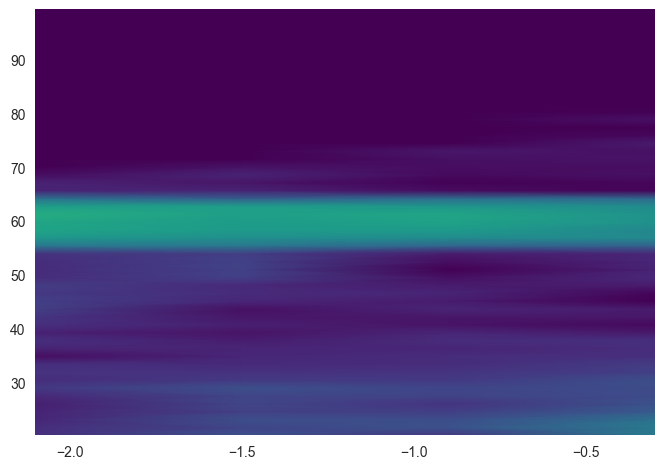

In [93]:
spectral.plot_coherogram(coherogram)